<a href="https://colab.research.google.com/github/sergioGarcia91/ML_Carolina_Bays/blob/main/15_U_Net_Train_7chanels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start

In [ ]:
!pip install tables

In [ ]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import h5py
import multiprocessing
import joblib

from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Verificar si CUDA (GPU) está disponible
if torch.cuda.is_available():
    print(f"GPU disponible: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    print("GPU no disponible, usando CPU.")

GPU disponible: NVIDIA A100-SXM4-40GB


In [ ]:
device

device(type='cuda')

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change Font of the Figures

In [ ]:
!wget https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf

--2025-05-21 01:08:55--  https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf [following]
--2025-05-21 01:08:55--  https://raw.githubusercontent.com/justrajdeep/fonts/master/Times%20New%20Roman.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834452 (815K) [application/octet-stream]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf 100%[===================>] 814.89K  --.-KB/s    in 0.05s   

2025-05-21 01:08:55 (14.7 MB/s) - ‘Times New Roman.ttf’ saved [834452/834452]



In [ ]:
import matplotlib.font_manager as fm

In [ ]:
# Path to the custom font
font_path = 'Times New Roman.ttf'

# Add the font to the Matplotlib font manager
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)

# Get the font name to use in rcParams
font_name = font_prop.get_name()
font_name

'Times New Roman'

In [ ]:
plt.rcParams['font.family'] = font_name

# Funtions

https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

In [ ]:
# import the necessary packages
#from . import config
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [ ]:
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		# store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, kernel_size=3, padding=1)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, kernel_size=3, padding=1)
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [ ]:
class Encoder(Module):
	def __init__(self, channels=(7, 16, 32, 64)):
		super().__init__()
		# store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		# return the list containing the intermediate outputs
		return blockOutputs

In [ ]:
class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		# return the final decoder output
		return x
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
		return encFeatures

In [ ]:
class UNet(Module):
  def __init__(self, encChannels=(7, 16, 32, 64),
              decChannels=(64, 32, 16),
              nbClasses=1, retainDim=True,
              #outSize=(config.INPUT_IMAGE_HEIGHT,  config.INPUT_IMAGE_WIDTH)):
              outSize=(64,  64)):
    super().__init__()
    # initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
    # initialize the regression head and store the class variables
    self.head = Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize

  def forward(self, x):
    # grab the features from the encoder
    encFeatures = self.encoder(x)
    # pass the encoder features through decoder making sure that
    # their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
    # pass the decoder features through the regression head to
    # obtain the segmentation mask
    map = self.head(decFeatures)
    # check to see if we are retaining the original output
    # dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
    # return the segmentation map

    return map

# Load Data

In [ ]:
path_save_h5 = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Dataset_h5'

h5_file = os.listdir(path_save_h5)
h5_file

['dataset_AOI_01_32x32.h5',
 'dataset_AOI_02_32x32.h5',
 'dataset_AOI_03_32x32.h5',
 'dataset_AOI_04_32x32.h5',
 'dataset_AOI_02_64x64.h5',
 'dataset_AOI_01_64x64.h5',
 'dataset_AOI_03_64x64.h5',
 'dataset_AOI_04_64x64.h5']

In [ ]:
# Abrir archivo en modo lectura
with h5py.File(os.path.join(path_save_h5,'dataset_AOI_01_64x64.h5'), 'r') as f:
    # Ver todas las claves del archivo (datasets o grupos)
    print("Keys:", list(f.keys()))

    # Acceder a un dataset específico
    data_X_1 = f['AOI_01_X'][::2]
    data_y_1 = f['AOI_01_y'][::2]
    print(data_X_1.shape, data_y_1.shape)

# Abrir archivo en modo lectura
with h5py.File(os.path.join(path_save_h5,'dataset_AOI_03_64x64.h5'), 'r') as f:
    # Ver todas las claves del archivo (datasets o grupos)
    print("Keys:", list(f.keys()))

    # Acceder a un dataset específico
    data_X_2 = f['AOI_03_X'][::2]
    data_y_2 = f['AOI_03_y'][::2]
    print(data_X_2.shape, data_y_2.shape)

data_X = np.concatenate((data_X_1, data_X_2), axis=0)
data_y = np.concatenate((data_y_1, data_y_2), axis=0)
print(data_X.shape, data_y.shape)

Keys: ['AOI_01_FC_percentaje', 'AOI_01_X', 'AOI_01_y']
(47250, 7, 64, 64) (47250, 64, 64)
Keys: ['AOI_03_FC_percentaje', 'AOI_03_X', 'AOI_03_y']
(47250, 7, 64, 64) (47250, 64, 64)
(94500, 7, 64, 64) (94500, 64, 64)


In [ ]:
data_X.shape, data_y.shape

((94500, 7, 64, 64), (94500, 64, 64))

## Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_X,
                                                    data_y,
                                                    test_size=0.2,
                                                    random_state=42)

In [ ]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train).unsqueeze(1).float()  # añade canal, y asegúrate de tipo float

print(X_train.shape, y_train.shape)

torch.Size([75600, 7, 64, 64]) torch.Size([75600, 1, 64, 64])


In [ ]:
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test).unsqueeze(1).float()  # añade canal, y asegúrate de tipo float#, dtype=torch.long).squeeze()

print(X_test.shape, y_test.shape)

torch.Size([18900, 7, 64, 64]) torch.Size([18900, 1, 64, 64])


In [ ]:
# Agrupar en un dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,# 32 con CPU GPU 01... 256 con GPU 02
                          shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,# 32 con CPU GPU 01 ... 256 con GPU 02
                         shuffle=False, num_workers=2)

## Train

In [ ]:
# import the necessary packages
#from pyimagesearch.dataset import SegmentationDataset
#from pyimagesearch.model import UNet
#from pyimagesearch import config
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import time
import os

In [ ]:
lr_unet = 0.0001

# initialize our UNet model
unet = UNet().to(device)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=lr_unet)
# calculate steps per epoch for training and test set
trainSteps = len(train_dataset) // BATCH_SIZE
testSteps = len(test_dataset) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [ ]:
NUM_EPOCHS = 400

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0
	# loop over the training set
	for (i, (x, y)) in enumerate(train_loader):
		# send the input to the device
		(x, y) = (x.to(device), y.to(device))
		# perform a forward pass and calculate the training loss
		pred = unet(x)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
		# loop over the validation set
		for (x, y) in test_loader:
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# make the predictions and calculate the validation loss
			pred = unet(x)
			totalTestLoss += lossFunc(pred, y)
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train loss: {:.6f}, Test loss: {:.4f}".format(
		avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

[INFO] training the network...


  0%|          | 1/400 [00:12<1:22:31, 12.41s/it]

[INFO] EPOCH: 1/400
Train loss: 0.427548, Test loss: 0.3559


  0%|          | 2/400 [00:22<1:14:53, 11.29s/it]

[INFO] EPOCH: 2/400
Train loss: 0.346138, Test loss: 0.3335


  1%|          | 3/400 [00:33<1:12:24, 10.94s/it]

[INFO] EPOCH: 3/400
Train loss: 0.324178, Test loss: 0.3194


  1%|          | 4/400 [00:43<1:11:03, 10.77s/it]

[INFO] EPOCH: 4/400
Train loss: 0.310381, Test loss: 0.3030


  1%|▏         | 5/400 [00:54<1:10:21, 10.69s/it]

[INFO] EPOCH: 5/400
Train loss: 0.300016, Test loss: 0.2952


  2%|▏         | 6/400 [01:05<1:09:50, 10.64s/it]

[INFO] EPOCH: 6/400
Train loss: 0.292098, Test loss: 0.2917


  2%|▏         | 7/400 [01:15<1:09:19, 10.58s/it]

[INFO] EPOCH: 7/400
Train loss: 0.286208, Test loss: 0.2829


  2%|▏         | 8/400 [01:26<1:09:09, 10.59s/it]

[INFO] EPOCH: 8/400
Train loss: 0.281715, Test loss: 0.2802


  2%|▏         | 9/400 [01:36<1:08:55, 10.58s/it]

[INFO] EPOCH: 9/400
Train loss: 0.279109, Test loss: 0.2784


  2%|▎         | 10/400 [01:47<1:08:40, 10.57s/it]

[INFO] EPOCH: 10/400
Train loss: 0.276627, Test loss: 0.2745


  3%|▎         | 11/400 [01:57<1:08:23, 10.55s/it]

[INFO] EPOCH: 11/400
Train loss: 0.274283, Test loss: 0.2736


  3%|▎         | 12/400 [02:08<1:08:13, 10.55s/it]

[INFO] EPOCH: 12/400
Train loss: 0.272273, Test loss: 0.2701


  3%|▎         | 13/400 [02:18<1:08:03, 10.55s/it]

[INFO] EPOCH: 13/400
Train loss: 0.270479, Test loss: 0.2692


  4%|▎         | 14/400 [02:29<1:07:50, 10.55s/it]

[INFO] EPOCH: 14/400
Train loss: 0.267555, Test loss: 0.2698


  4%|▍         | 15/400 [02:39<1:07:39, 10.54s/it]

[INFO] EPOCH: 15/400
Train loss: 0.266402, Test loss: 0.2645


  4%|▍         | 16/400 [02:50<1:07:25, 10.53s/it]

[INFO] EPOCH: 16/400
Train loss: 0.264754, Test loss: 0.2621


  4%|▍         | 17/400 [03:00<1:07:16, 10.54s/it]

[INFO] EPOCH: 17/400
Train loss: 0.263218, Test loss: 0.2622


  4%|▍         | 18/400 [03:11<1:07:05, 10.54s/it]

[INFO] EPOCH: 18/400
Train loss: 0.261741, Test loss: 0.2669


  5%|▍         | 19/400 [03:22<1:06:54, 10.54s/it]

[INFO] EPOCH: 19/400
Train loss: 0.259664, Test loss: 0.2614


  5%|▌         | 20/400 [03:32<1:06:41, 10.53s/it]

[INFO] EPOCH: 20/400
Train loss: 0.257986, Test loss: 0.2629


  5%|▌         | 21/400 [03:43<1:06:58, 10.60s/it]

[INFO] EPOCH: 21/400
Train loss: 0.255735, Test loss: 0.2545


  6%|▌         | 22/400 [03:53<1:06:42, 10.59s/it]

[INFO] EPOCH: 22/400
Train loss: 0.253881, Test loss: 0.2516


  6%|▌         | 23/400 [04:04<1:06:22, 10.56s/it]

[INFO] EPOCH: 23/400
Train loss: 0.253191, Test loss: 0.2518


  6%|▌         | 24/400 [04:14<1:06:05, 10.55s/it]

[INFO] EPOCH: 24/400
Train loss: 0.250673, Test loss: 0.2517


  6%|▋         | 25/400 [04:25<1:05:55, 10.55s/it]

[INFO] EPOCH: 25/400
Train loss: 0.249532, Test loss: 0.2486


  6%|▋         | 26/400 [04:35<1:05:37, 10.53s/it]

[INFO] EPOCH: 26/400
Train loss: 0.246794, Test loss: 0.2456


  7%|▋         | 27/400 [04:46<1:05:22, 10.52s/it]

[INFO] EPOCH: 27/400
Train loss: 0.244831, Test loss: 0.2511


  7%|▋         | 28/400 [04:56<1:05:17, 10.53s/it]

[INFO] EPOCH: 28/400
Train loss: 0.243606, Test loss: 0.2574


  7%|▋         | 29/400 [05:07<1:05:07, 10.53s/it]

[INFO] EPOCH: 29/400
Train loss: 0.242598, Test loss: 0.2457


  8%|▊         | 30/400 [05:18<1:04:55, 10.53s/it]

[INFO] EPOCH: 30/400
Train loss: 0.238085, Test loss: 0.2348


  8%|▊         | 31/400 [05:28<1:04:42, 10.52s/it]

[INFO] EPOCH: 31/400
Train loss: 0.236828, Test loss: 0.2357


  8%|▊         | 32/400 [05:38<1:04:27, 10.51s/it]

[INFO] EPOCH: 32/400
Train loss: 0.234512, Test loss: 0.2318


  8%|▊         | 33/400 [05:49<1:04:23, 10.53s/it]

[INFO] EPOCH: 33/400
Train loss: 0.231931, Test loss: 0.2299


  8%|▊         | 34/400 [06:00<1:04:24, 10.56s/it]

[INFO] EPOCH: 34/400
Train loss: 0.229605, Test loss: 0.2275


  9%|▉         | 35/400 [06:10<1:04:10, 10.55s/it]

[INFO] EPOCH: 35/400
Train loss: 0.227445, Test loss: 0.2231


  9%|▉         | 36/400 [06:21<1:04:00, 10.55s/it]

[INFO] EPOCH: 36/400
Train loss: 0.224191, Test loss: 0.2223


  9%|▉         | 37/400 [06:31<1:03:42, 10.53s/it]

[INFO] EPOCH: 37/400
Train loss: 0.223083, Test loss: 0.2223


 10%|▉         | 38/400 [06:42<1:03:30, 10.53s/it]

[INFO] EPOCH: 38/400
Train loss: 0.220200, Test loss: 0.2161


 10%|▉         | 39/400 [06:52<1:03:14, 10.51s/it]

[INFO] EPOCH: 39/400
Train loss: 0.221406, Test loss: 0.2145


 10%|█         | 40/400 [07:03<1:03:03, 10.51s/it]

[INFO] EPOCH: 40/400
Train loss: 0.215364, Test loss: 0.2338


 10%|█         | 41/400 [07:13<1:02:53, 10.51s/it]

[INFO] EPOCH: 41/400
Train loss: 0.214356, Test loss: 0.2287


 10%|█         | 42/400 [07:24<1:02:44, 10.52s/it]

[INFO] EPOCH: 42/400
Train loss: 0.211483, Test loss: 0.2106


 11%|█         | 43/400 [07:34<1:02:30, 10.51s/it]

[INFO] EPOCH: 43/400
Train loss: 0.209657, Test loss: 0.2094


 11%|█         | 44/400 [07:45<1:02:18, 10.50s/it]

[INFO] EPOCH: 44/400
Train loss: 0.208569, Test loss: 0.2089


 11%|█▏        | 45/400 [07:55<1:02:08, 10.50s/it]

[INFO] EPOCH: 45/400
Train loss: 0.205632, Test loss: 0.2094


 12%|█▏        | 46/400 [08:06<1:01:58, 10.50s/it]

[INFO] EPOCH: 46/400
Train loss: 0.202909, Test loss: 0.2049


 12%|█▏        | 47/400 [08:16<1:01:50, 10.51s/it]

[INFO] EPOCH: 47/400
Train loss: 0.203138, Test loss: 0.2005


 12%|█▏        | 48/400 [08:27<1:01:42, 10.52s/it]

[INFO] EPOCH: 48/400
Train loss: 0.199807, Test loss: 0.2073


 12%|█▏        | 49/400 [08:37<1:01:31, 10.52s/it]

[INFO] EPOCH: 49/400
Train loss: 0.198553, Test loss: 0.1947


 12%|█▎        | 50/400 [08:48<1:01:21, 10.52s/it]

[INFO] EPOCH: 50/400
Train loss: 0.194790, Test loss: 0.1938


 13%|█▎        | 51/400 [08:58<1:01:12, 10.52s/it]

[INFO] EPOCH: 51/400
Train loss: 0.193165, Test loss: 0.1910


 13%|█▎        | 52/400 [09:09<1:01:05, 10.53s/it]

[INFO] EPOCH: 52/400
Train loss: 0.192626, Test loss: 0.1898


 13%|█▎        | 53/400 [09:20<1:01:01, 10.55s/it]

[INFO] EPOCH: 53/400
Train loss: 0.191117, Test loss: 0.1869


 14%|█▎        | 54/400 [09:30<1:00:52, 10.56s/it]

[INFO] EPOCH: 54/400
Train loss: 0.188334, Test loss: 0.1906


 14%|█▍        | 55/400 [09:41<1:00:36, 10.54s/it]

[INFO] EPOCH: 55/400
Train loss: 0.187880, Test loss: 0.1843


 14%|█▍        | 56/400 [09:51<1:00:22, 10.53s/it]

[INFO] EPOCH: 56/400
Train loss: 0.185429, Test loss: 0.1911


 14%|█▍        | 57/400 [10:02<1:00:12, 10.53s/it]

[INFO] EPOCH: 57/400
Train loss: 0.184191, Test loss: 0.1799


 14%|█▍        | 58/400 [10:12<1:00:05, 10.54s/it]

[INFO] EPOCH: 58/400
Train loss: 0.181389, Test loss: 0.1780


 15%|█▍        | 59/400 [10:23<59:59, 10.55s/it]  

[INFO] EPOCH: 59/400
Train loss: 0.182961, Test loss: 0.1964


 15%|█▌        | 60/400 [10:33<59:44, 10.54s/it]

[INFO] EPOCH: 60/400
Train loss: 0.179655, Test loss: 0.1811


 15%|█▌        | 61/400 [10:44<59:34, 10.54s/it]

[INFO] EPOCH: 61/400
Train loss: 0.178951, Test loss: 0.1781


 16%|█▌        | 62/400 [10:54<59:17, 10.53s/it]

[INFO] EPOCH: 62/400
Train loss: 0.175432, Test loss: 0.1848


 16%|█▌        | 63/400 [11:05<59:14, 10.55s/it]

[INFO] EPOCH: 63/400
Train loss: 0.174578, Test loss: 0.1857


 16%|█▌        | 64/400 [11:15<58:58, 10.53s/it]

[INFO] EPOCH: 64/400
Train loss: 0.175553, Test loss: 0.1698


 16%|█▋        | 65/400 [11:26<58:47, 10.53s/it]

[INFO] EPOCH: 65/400
Train loss: 0.172558, Test loss: 0.1865


 16%|█▋        | 66/400 [11:37<58:55, 10.58s/it]

[INFO] EPOCH: 66/400
Train loss: 0.170315, Test loss: 0.1767


 17%|█▋        | 67/400 [11:47<58:37, 10.56s/it]

[INFO] EPOCH: 67/400
Train loss: 0.171486, Test loss: 0.1865


 17%|█▋        | 68/400 [11:58<58:21, 10.55s/it]

[INFO] EPOCH: 68/400
Train loss: 0.169149, Test loss: 0.1649


 17%|█▋        | 69/400 [12:08<58:04, 10.53s/it]

[INFO] EPOCH: 69/400
Train loss: 0.168520, Test loss: 0.1654


 18%|█▊        | 70/400 [12:19<57:54, 10.53s/it]

[INFO] EPOCH: 70/400
Train loss: 0.165585, Test loss: 0.1794


 18%|█▊        | 71/400 [12:29<57:49, 10.55s/it]

[INFO] EPOCH: 71/400
Train loss: 0.165319, Test loss: 0.1604


 18%|█▊        | 72/400 [12:40<57:41, 10.55s/it]

[INFO] EPOCH: 72/400
Train loss: 0.164846, Test loss: 0.1682


 18%|█▊        | 73/400 [12:50<57:26, 10.54s/it]

[INFO] EPOCH: 73/400
Train loss: 0.164383, Test loss: 0.1627


 18%|█▊        | 74/400 [13:01<57:09, 10.52s/it]

[INFO] EPOCH: 74/400
Train loss: 0.163340, Test loss: 0.1640


 19%|█▉        | 75/400 [13:12<57:12, 10.56s/it]

[INFO] EPOCH: 75/400
Train loss: 0.161464, Test loss: 0.1568


 19%|█▉        | 76/400 [13:22<57:04, 10.57s/it]

[INFO] EPOCH: 76/400
Train loss: 0.159704, Test loss: 0.1586


 19%|█▉        | 77/400 [13:33<56:46, 10.55s/it]

[INFO] EPOCH: 77/400
Train loss: 0.158724, Test loss: 0.1615


 20%|█▉        | 78/400 [13:43<56:44, 10.57s/it]

[INFO] EPOCH: 78/400
Train loss: 0.157888, Test loss: 0.1542


 20%|█▉        | 79/400 [13:54<56:30, 10.56s/it]

[INFO] EPOCH: 79/400
Train loss: 0.155780, Test loss: 0.1519


 20%|██        | 80/400 [14:04<56:16, 10.55s/it]

[INFO] EPOCH: 80/400
Train loss: 0.155812, Test loss: 0.1594


 20%|██        | 81/400 [14:15<56:05, 10.55s/it]

[INFO] EPOCH: 81/400
Train loss: 0.154375, Test loss: 0.1509


 20%|██        | 82/400 [14:25<55:52, 10.54s/it]

[INFO] EPOCH: 82/400
Train loss: 0.155391, Test loss: 0.1521


 21%|██        | 83/400 [14:36<55:43, 10.55s/it]

[INFO] EPOCH: 83/400
Train loss: 0.154089, Test loss: 0.1496


 21%|██        | 84/400 [14:47<55:47, 10.59s/it]

[INFO] EPOCH: 84/400
Train loss: 0.150898, Test loss: 0.1477


 21%|██▏       | 85/400 [14:57<55:30, 10.57s/it]

[INFO] EPOCH: 85/400
Train loss: 0.150042, Test loss: 0.1472


 22%|██▏       | 86/400 [15:08<55:19, 10.57s/it]

[INFO] EPOCH: 86/400
Train loss: 0.149667, Test loss: 0.1510


 22%|██▏       | 87/400 [15:18<55:18, 10.60s/it]

[INFO] EPOCH: 87/400
Train loss: 0.149277, Test loss: 0.1493


 22%|██▏       | 88/400 [15:29<55:03, 10.59s/it]

[INFO] EPOCH: 88/400
Train loss: 0.150675, Test loss: 0.1456


 22%|██▏       | 89/400 [15:40<54:53, 10.59s/it]

[INFO] EPOCH: 89/400
Train loss: 0.146646, Test loss: 0.1514


 22%|██▎       | 90/400 [15:50<54:40, 10.58s/it]

[INFO] EPOCH: 90/400
Train loss: 0.146589, Test loss: 0.1431


 23%|██▎       | 91/400 [16:01<54:30, 10.58s/it]

[INFO] EPOCH: 91/400
Train loss: 0.144822, Test loss: 0.1411


 23%|██▎       | 92/400 [16:11<54:23, 10.60s/it]

[INFO] EPOCH: 92/400
Train loss: 0.146477, Test loss: 0.1534


 23%|██▎       | 93/400 [16:22<54:13, 10.60s/it]

[INFO] EPOCH: 93/400
Train loss: 0.143922, Test loss: 0.1395


 24%|██▎       | 94/400 [16:33<54:07, 10.61s/it]

[INFO] EPOCH: 94/400
Train loss: 0.147783, Test loss: 0.1421


 24%|██▍       | 95/400 [16:43<53:52, 10.60s/it]

[INFO] EPOCH: 95/400
Train loss: 0.141341, Test loss: 0.1409


 24%|██▍       | 96/400 [16:54<53:31, 10.56s/it]

[INFO] EPOCH: 96/400
Train loss: 0.142345, Test loss: 0.1486


 24%|██▍       | 97/400 [17:04<53:16, 10.55s/it]

[INFO] EPOCH: 97/400
Train loss: 0.142519, Test loss: 0.1368


 24%|██▍       | 98/400 [17:15<53:01, 10.53s/it]

[INFO] EPOCH: 98/400
Train loss: 0.139851, Test loss: 0.1395


 25%|██▍       | 99/400 [17:25<52:49, 10.53s/it]

[INFO] EPOCH: 99/400
Train loss: 0.139374, Test loss: 0.1790


 25%|██▌       | 100/400 [17:36<52:39, 10.53s/it]

[INFO] EPOCH: 100/400
Train loss: 0.140496, Test loss: 0.1359


 25%|██▌       | 101/400 [17:46<52:34, 10.55s/it]

[INFO] EPOCH: 101/400
Train loss: 0.136608, Test loss: 0.1331


 26%|██▌       | 102/400 [17:57<52:20, 10.54s/it]

[INFO] EPOCH: 102/400
Train loss: 0.135902, Test loss: 0.1340


 26%|██▌       | 103/400 [18:07<52:09, 10.54s/it]

[INFO] EPOCH: 103/400
Train loss: 0.137099, Test loss: 0.1334


 26%|██▌       | 104/400 [18:18<51:56, 10.53s/it]

[INFO] EPOCH: 104/400
Train loss: 0.134942, Test loss: 0.1699


 26%|██▋       | 105/400 [18:28<51:48, 10.54s/it]

[INFO] EPOCH: 105/400
Train loss: 0.138644, Test loss: 0.1355


 26%|██▋       | 106/400 [18:39<51:38, 10.54s/it]

[INFO] EPOCH: 106/400
Train loss: 0.133435, Test loss: 0.1313


 27%|██▋       | 107/400 [18:50<51:27, 10.54s/it]

[INFO] EPOCH: 107/400
Train loss: 0.135492, Test loss: 0.1424


 27%|██▋       | 108/400 [19:00<51:21, 10.55s/it]

[INFO] EPOCH: 108/400
Train loss: 0.132373, Test loss: 0.1499


 27%|██▋       | 109/400 [19:11<51:09, 10.55s/it]

[INFO] EPOCH: 109/400
Train loss: 0.132285, Test loss: 0.1290


 28%|██▊       | 110/400 [19:21<50:56, 10.54s/it]

[INFO] EPOCH: 110/400
Train loss: 0.133503, Test loss: 0.1357


 28%|██▊       | 111/400 [19:32<50:51, 10.56s/it]

[INFO] EPOCH: 111/400
Train loss: 0.132085, Test loss: 0.1942


 28%|██▊       | 112/400 [19:42<50:36, 10.54s/it]

[INFO] EPOCH: 112/400
Train loss: 0.137312, Test loss: 0.1276


 28%|██▊       | 113/400 [19:53<50:24, 10.54s/it]

[INFO] EPOCH: 113/400
Train loss: 0.130283, Test loss: 0.1270


 28%|██▊       | 114/400 [20:03<50:12, 10.53s/it]

[INFO] EPOCH: 114/400
Train loss: 0.129570, Test loss: 0.1298


 29%|██▉       | 115/400 [20:14<50:00, 10.53s/it]

[INFO] EPOCH: 115/400
Train loss: 0.130510, Test loss: 0.1312


 29%|██▉       | 116/400 [20:24<49:52, 10.54s/it]

[INFO] EPOCH: 116/400
Train loss: 0.127848, Test loss: 0.1317


 29%|██▉       | 117/400 [20:35<49:42, 10.54s/it]

[INFO] EPOCH: 117/400
Train loss: 0.133295, Test loss: 0.1261


 30%|██▉       | 118/400 [20:45<49:32, 10.54s/it]

[INFO] EPOCH: 118/400
Train loss: 0.126066, Test loss: 0.1274


 30%|██▉       | 119/400 [20:56<49:17, 10.53s/it]

[INFO] EPOCH: 119/400
Train loss: 0.128259, Test loss: 0.1268


 30%|███       | 120/400 [21:06<49:06, 10.52s/it]

[INFO] EPOCH: 120/400
Train loss: 0.125906, Test loss: 0.1245


 30%|███       | 121/400 [21:17<48:57, 10.53s/it]

[INFO] EPOCH: 121/400
Train loss: 0.124523, Test loss: 0.1221


 30%|███       | 122/400 [21:28<48:48, 10.53s/it]

[INFO] EPOCH: 122/400
Train loss: 0.130969, Test loss: 0.1211


 31%|███       | 123/400 [21:38<48:38, 10.54s/it]

[INFO] EPOCH: 123/400
Train loss: 0.122432, Test loss: 0.1232


 31%|███       | 124/400 [21:49<48:31, 10.55s/it]

[INFO] EPOCH: 124/400
Train loss: 0.127323, Test loss: 0.1253


 31%|███▏      | 125/400 [21:59<48:25, 10.56s/it]

[INFO] EPOCH: 125/400
Train loss: 0.123546, Test loss: 0.1313


 32%|███▏      | 126/400 [22:10<48:11, 10.55s/it]

[INFO] EPOCH: 126/400
Train loss: 0.124492, Test loss: 0.1236


 32%|███▏      | 127/400 [22:20<48:03, 10.56s/it]

[INFO] EPOCH: 127/400
Train loss: 0.122496, Test loss: 0.1215


 32%|███▏      | 128/400 [22:31<47:50, 10.55s/it]

[INFO] EPOCH: 128/400
Train loss: 0.121176, Test loss: 0.1422


 32%|███▏      | 129/400 [22:41<47:39, 10.55s/it]

[INFO] EPOCH: 129/400
Train loss: 0.124084, Test loss: 0.1168


 32%|███▎      | 130/400 [22:52<47:27, 10.54s/it]

[INFO] EPOCH: 130/400
Train loss: 0.120480, Test loss: 0.1206


 33%|███▎      | 131/400 [23:03<47:17, 10.55s/it]

[INFO] EPOCH: 131/400
Train loss: 0.120736, Test loss: 0.1183


 33%|███▎      | 132/400 [23:13<47:08, 10.55s/it]

[INFO] EPOCH: 132/400
Train loss: 0.121830, Test loss: 0.1171


 33%|███▎      | 133/400 [23:24<46:55, 10.55s/it]

[INFO] EPOCH: 133/400
Train loss: 0.126445, Test loss: 0.1281


 34%|███▎      | 134/400 [23:34<46:43, 10.54s/it]

[INFO] EPOCH: 134/400
Train loss: 0.118893, Test loss: 0.1175


 34%|███▍      | 135/400 [23:45<46:30, 10.53s/it]

[INFO] EPOCH: 135/400
Train loss: 0.118194, Test loss: 0.1204


 34%|███▍      | 136/400 [23:55<46:18, 10.52s/it]

[INFO] EPOCH: 136/400
Train loss: 0.130426, Test loss: 0.1193


 34%|███▍      | 137/400 [24:06<46:10, 10.54s/it]

[INFO] EPOCH: 137/400
Train loss: 0.118807, Test loss: 0.1157


 34%|███▍      | 138/400 [24:16<46:05, 10.56s/it]

[INFO] EPOCH: 138/400
Train loss: 0.117375, Test loss: 0.1205


 35%|███▍      | 139/400 [24:27<45:55, 10.56s/it]

[INFO] EPOCH: 139/400
Train loss: 0.117880, Test loss: 0.1166


 35%|███▌      | 140/400 [24:38<46:05, 10.64s/it]

[INFO] EPOCH: 140/400
Train loss: 0.117610, Test loss: 0.1156


 35%|███▌      | 141/400 [24:49<46:07, 10.69s/it]

[INFO] EPOCH: 141/400
Train loss: 0.117453, Test loss: 0.1162


 36%|███▌      | 142/400 [24:59<46:03, 10.71s/it]

[INFO] EPOCH: 142/400
Train loss: 0.116873, Test loss: 0.1194


 36%|███▌      | 143/400 [25:10<45:58, 10.73s/it]

[INFO] EPOCH: 143/400
Train loss: 0.113520, Test loss: 0.1171


 36%|███▌      | 144/400 [25:21<45:54, 10.76s/it]

[INFO] EPOCH: 144/400
Train loss: 0.115630, Test loss: 0.1322


 36%|███▋      | 145/400 [25:32<45:52, 10.79s/it]

[INFO] EPOCH: 145/400
Train loss: 0.122962, Test loss: 0.1191


 36%|███▋      | 146/400 [25:43<45:39, 10.79s/it]

[INFO] EPOCH: 146/400
Train loss: 0.112584, Test loss: 0.1099


 37%|███▋      | 147/400 [25:53<45:28, 10.78s/it]

[INFO] EPOCH: 147/400
Train loss: 0.112073, Test loss: 0.1133


 37%|███▋      | 148/400 [26:04<45:18, 10.79s/it]

[INFO] EPOCH: 148/400
Train loss: 0.115380, Test loss: 0.1099


 37%|███▋      | 149/400 [26:15<45:09, 10.79s/it]

[INFO] EPOCH: 149/400
Train loss: 0.112182, Test loss: 0.1103


 38%|███▊      | 150/400 [26:26<44:56, 10.79s/it]

[INFO] EPOCH: 150/400
Train loss: 0.113798, Test loss: 0.1158


 38%|███▊      | 151/400 [26:37<44:49, 10.80s/it]

[INFO] EPOCH: 151/400
Train loss: 0.111406, Test loss: 0.1083


 38%|███▊      | 152/400 [26:47<44:37, 10.80s/it]

[INFO] EPOCH: 152/400
Train loss: 0.112616, Test loss: 0.1094


 38%|███▊      | 153/400 [26:58<44:46, 10.88s/it]

[INFO] EPOCH: 153/400
Train loss: 0.110142, Test loss: 0.1082


 38%|███▊      | 154/400 [27:09<44:27, 10.84s/it]

[INFO] EPOCH: 154/400
Train loss: 0.114798, Test loss: 0.1092


 39%|███▉      | 155/400 [27:20<44:12, 10.83s/it]

[INFO] EPOCH: 155/400
Train loss: 0.109594, Test loss: 0.1093


 39%|███▉      | 156/400 [27:31<43:59, 10.82s/it]

[INFO] EPOCH: 156/400
Train loss: 0.109359, Test loss: 0.3940


 39%|███▉      | 157/400 [27:42<43:53, 10.84s/it]

[INFO] EPOCH: 157/400
Train loss: 0.131645, Test loss: 0.1061


 40%|███▉      | 158/400 [27:52<43:39, 10.82s/it]

[INFO] EPOCH: 158/400
Train loss: 0.108784, Test loss: 0.1061


 40%|███▉      | 159/400 [28:03<43:28, 10.82s/it]

[INFO] EPOCH: 159/400
Train loss: 0.111833, Test loss: 0.1187


 40%|████      | 160/400 [28:14<43:21, 10.84s/it]

[INFO] EPOCH: 160/400
Train loss: 0.107898, Test loss: 0.1085


 40%|████      | 161/400 [28:25<43:06, 10.82s/it]

[INFO] EPOCH: 161/400
Train loss: 0.108774, Test loss: 0.1049


 40%|████      | 162/400 [28:36<42:52, 10.81s/it]

[INFO] EPOCH: 162/400
Train loss: 0.107814, Test loss: 0.1119


 41%|████      | 163/400 [28:46<42:40, 10.80s/it]

[INFO] EPOCH: 163/400
Train loss: 0.106251, Test loss: 0.1030


 41%|████      | 164/400 [28:57<42:31, 10.81s/it]

[INFO] EPOCH: 164/400
Train loss: 0.125480, Test loss: 0.1066


 41%|████▏     | 165/400 [29:08<42:19, 10.81s/it]

[INFO] EPOCH: 165/400
Train loss: 0.106752, Test loss: 0.1025


 42%|████▏     | 166/400 [29:19<42:06, 10.80s/it]

[INFO] EPOCH: 166/400
Train loss: 0.108586, Test loss: 0.1037


 42%|████▏     | 167/400 [29:30<42:08, 10.85s/it]

[INFO] EPOCH: 167/400
Train loss: 0.105962, Test loss: 0.1020


 42%|████▏     | 168/400 [29:41<41:53, 10.83s/it]

[INFO] EPOCH: 168/400
Train loss: 0.126387, Test loss: 0.1031


 42%|████▏     | 169/400 [29:51<41:37, 10.81s/it]

[INFO] EPOCH: 169/400
Train loss: 0.106608, Test loss: 0.1276


 42%|████▎     | 170/400 [30:02<41:24, 10.80s/it]

[INFO] EPOCH: 170/400
Train loss: 0.109143, Test loss: 0.1119


 43%|████▎     | 171/400 [30:13<41:11, 10.79s/it]

[INFO] EPOCH: 171/400
Train loss: 0.105849, Test loss: 0.1019


 43%|████▎     | 172/400 [30:24<40:57, 10.78s/it]

[INFO] EPOCH: 172/400
Train loss: 0.104432, Test loss: 0.1065


 43%|████▎     | 173/400 [30:35<40:51, 10.80s/it]

[INFO] EPOCH: 173/400
Train loss: 0.108405, Test loss: 0.1013


 44%|████▎     | 174/400 [30:45<40:38, 10.79s/it]

[INFO] EPOCH: 174/400
Train loss: 0.103759, Test loss: 0.1174


 44%|████▍     | 175/400 [30:56<40:27, 10.79s/it]

[INFO] EPOCH: 175/400
Train loss: 0.115405, Test loss: 0.0996


 44%|████▍     | 176/400 [31:07<40:17, 10.79s/it]

[INFO] EPOCH: 176/400
Train loss: 0.101228, Test loss: 0.0996


 44%|████▍     | 177/400 [31:18<40:11, 10.81s/it]

[INFO] EPOCH: 177/400
Train loss: 0.102025, Test loss: 0.1093


 44%|████▍     | 178/400 [31:29<39:58, 10.80s/it]

[INFO] EPOCH: 178/400
Train loss: 0.108141, Test loss: 0.0979


 45%|████▍     | 179/400 [31:39<39:46, 10.80s/it]

[INFO] EPOCH: 179/400
Train loss: 0.102389, Test loss: 0.1013


 45%|████▌     | 180/400 [31:50<39:37, 10.81s/it]

[INFO] EPOCH: 180/400
Train loss: 0.100406, Test loss: 0.0986


 45%|████▌     | 181/400 [32:01<39:26, 10.81s/it]

[INFO] EPOCH: 181/400
Train loss: 0.101812, Test loss: 0.0980


 46%|████▌     | 182/400 [32:12<39:15, 10.80s/it]

[INFO] EPOCH: 182/400
Train loss: 0.107354, Test loss: 0.1038


 46%|████▌     | 183/400 [32:23<39:03, 10.80s/it]

[INFO] EPOCH: 183/400
Train loss: 0.099303, Test loss: 0.0963


 46%|████▌     | 184/400 [32:33<38:50, 10.79s/it]

[INFO] EPOCH: 184/400
Train loss: 0.103079, Test loss: 0.0976


 46%|████▋     | 185/400 [32:44<38:39, 10.79s/it]

[INFO] EPOCH: 185/400
Train loss: 0.099637, Test loss: 0.0989


 46%|████▋     | 186/400 [32:55<38:30, 10.80s/it]

[INFO] EPOCH: 186/400
Train loss: 0.101448, Test loss: 0.0958


 47%|████▋     | 187/400 [33:06<38:22, 10.81s/it]

[INFO] EPOCH: 187/400
Train loss: 0.102584, Test loss: 0.1025


 47%|████▋     | 188/400 [33:17<38:13, 10.82s/it]

[INFO] EPOCH: 188/400
Train loss: 0.097972, Test loss: 0.0953


 47%|████▋     | 189/400 [33:27<37:59, 10.80s/it]

[INFO] EPOCH: 189/400
Train loss: 0.101316, Test loss: 0.0949


 48%|████▊     | 190/400 [33:38<37:48, 10.80s/it]

[INFO] EPOCH: 190/400
Train loss: 0.106996, Test loss: 0.1065


 48%|████▊     | 191/400 [33:49<37:34, 10.79s/it]

[INFO] EPOCH: 191/400
Train loss: 0.096670, Test loss: 0.0940


 48%|████▊     | 192/400 [34:00<37:22, 10.78s/it]

[INFO] EPOCH: 192/400
Train loss: 0.096423, Test loss: 0.1302


 48%|████▊     | 193/400 [34:11<37:14, 10.79s/it]

[INFO] EPOCH: 193/400
Train loss: 0.100991, Test loss: 0.1012


 48%|████▊     | 194/400 [34:21<37:05, 10.80s/it]

[INFO] EPOCH: 194/400
Train loss: 0.103087, Test loss: 0.1004


 49%|████▉     | 195/400 [34:32<36:57, 10.82s/it]

[INFO] EPOCH: 195/400
Train loss: 0.098199, Test loss: 0.0981


 49%|████▉     | 196/400 [34:43<36:48, 10.83s/it]

[INFO] EPOCH: 196/400
Train loss: 0.095363, Test loss: 0.0926


 49%|████▉     | 197/400 [34:54<36:51, 10.89s/it]

[INFO] EPOCH: 197/400
Train loss: 0.102110, Test loss: 0.0923


 50%|████▉     | 198/400 [35:05<36:52, 10.95s/it]

[INFO] EPOCH: 198/400
Train loss: 0.094917, Test loss: 0.0942


 50%|████▉     | 199/400 [35:16<36:35, 10.92s/it]

[INFO] EPOCH: 199/400
Train loss: 0.096896, Test loss: 0.0952


 50%|█████     | 200/400 [35:27<36:22, 10.91s/it]

[INFO] EPOCH: 200/400
Train loss: 0.096743, Test loss: 0.0956


 50%|█████     | 201/400 [35:38<36:11, 10.91s/it]

[INFO] EPOCH: 201/400
Train loss: 0.095060, Test loss: 0.0924


 50%|█████     | 202/400 [35:49<35:54, 10.88s/it]

[INFO] EPOCH: 202/400
Train loss: 0.094955, Test loss: 0.0913


 51%|█████     | 203/400 [35:59<35:40, 10.87s/it]

[INFO] EPOCH: 203/400
Train loss: 0.093521, Test loss: 0.0935


 51%|█████     | 204/400 [36:10<35:28, 10.86s/it]

[INFO] EPOCH: 204/400
Train loss: 0.098685, Test loss: 0.0935


 51%|█████▏    | 205/400 [36:21<35:23, 10.89s/it]

[INFO] EPOCH: 205/400
Train loss: 0.092313, Test loss: 0.0901


 52%|█████▏    | 206/400 [36:32<35:09, 10.87s/it]

[INFO] EPOCH: 206/400
Train loss: 0.093225, Test loss: 0.0902


 52%|█████▏    | 207/400 [36:43<35:05, 10.91s/it]

[INFO] EPOCH: 207/400
Train loss: 0.094794, Test loss: 0.0903


 52%|█████▏    | 208/400 [36:54<35:02, 10.95s/it]

[INFO] EPOCH: 208/400
Train loss: 0.093110, Test loss: 0.0965


 52%|█████▏    | 209/400 [37:05<34:45, 10.92s/it]

[INFO] EPOCH: 209/400
Train loss: 0.095527, Test loss: 0.0980


 52%|█████▎    | 210/400 [37:16<34:28, 10.89s/it]

[INFO] EPOCH: 210/400
Train loss: 0.092749, Test loss: 0.0900


 53%|█████▎    | 211/400 [37:27<34:11, 10.86s/it]

[INFO] EPOCH: 211/400
Train loss: 0.094930, Test loss: 0.0910


 53%|█████▎    | 212/400 [37:37<33:57, 10.84s/it]

[INFO] EPOCH: 212/400
Train loss: 0.096304, Test loss: 0.0897


 53%|█████▎    | 213/400 [37:48<33:43, 10.82s/it]

[INFO] EPOCH: 213/400
Train loss: 0.091681, Test loss: 0.0880


 54%|█████▎    | 214/400 [37:59<33:31, 10.82s/it]

[INFO] EPOCH: 214/400
Train loss: 0.090366, Test loss: 0.0889


 54%|█████▍    | 215/400 [38:10<33:20, 10.82s/it]

[INFO] EPOCH: 215/400
Train loss: 0.115453, Test loss: 0.0900


 54%|█████▍    | 216/400 [38:21<33:09, 10.81s/it]

[INFO] EPOCH: 216/400
Train loss: 0.090373, Test loss: 0.0879


 54%|█████▍    | 217/400 [38:31<32:56, 10.80s/it]

[INFO] EPOCH: 217/400
Train loss: 0.112394, Test loss: 0.0894


 55%|█████▍    | 218/400 [38:42<32:41, 10.78s/it]

[INFO] EPOCH: 218/400
Train loss: 0.089278, Test loss: 0.0897


 55%|█████▍    | 219/400 [38:53<32:31, 10.78s/it]

[INFO] EPOCH: 219/400
Train loss: 0.091296, Test loss: 0.0869


 55%|█████▌    | 220/400 [39:04<32:31, 10.84s/it]

[INFO] EPOCH: 220/400
Train loss: 0.089180, Test loss: 0.0993


 55%|█████▌    | 221/400 [39:15<32:32, 10.91s/it]

[INFO] EPOCH: 221/400
Train loss: 0.090320, Test loss: 0.0984


 56%|█████▌    | 222/400 [39:26<32:29, 10.95s/it]

[INFO] EPOCH: 222/400
Train loss: 0.093036, Test loss: 0.0946


 56%|█████▌    | 223/400 [39:37<32:22, 10.97s/it]

[INFO] EPOCH: 223/400
Train loss: 0.089011, Test loss: 0.0867


 56%|█████▌    | 224/400 [39:48<32:18, 11.01s/it]

[INFO] EPOCH: 224/400
Train loss: 0.129258, Test loss: 0.1093


 56%|█████▋    | 225/400 [39:59<32:10, 11.03s/it]

[INFO] EPOCH: 225/400
Train loss: 0.092635, Test loss: 0.0871


 56%|█████▋    | 226/400 [40:10<31:59, 11.03s/it]

[INFO] EPOCH: 226/400
Train loss: 0.089613, Test loss: 0.0873


 57%|█████▋    | 227/400 [40:21<31:51, 11.05s/it]

[INFO] EPOCH: 227/400
Train loss: 0.088064, Test loss: 0.0863


 57%|█████▋    | 228/400 [40:32<31:41, 11.06s/it]

[INFO] EPOCH: 228/400
Train loss: 0.089279, Test loss: 0.0909


 57%|█████▋    | 229/400 [40:44<31:44, 11.14s/it]

[INFO] EPOCH: 229/400
Train loss: 0.088186, Test loss: 0.0864


 57%|█████▊    | 230/400 [40:55<31:28, 11.11s/it]

[INFO] EPOCH: 230/400
Train loss: 0.087346, Test loss: 0.0842


 58%|█████▊    | 231/400 [41:06<31:15, 11.10s/it]

[INFO] EPOCH: 231/400
Train loss: 0.113011, Test loss: 0.0871


 58%|█████▊    | 232/400 [41:17<30:59, 11.07s/it]

[INFO] EPOCH: 232/400
Train loss: 0.087349, Test loss: 0.0845


 58%|█████▊    | 233/400 [41:28<30:49, 11.08s/it]

[INFO] EPOCH: 233/400
Train loss: 0.101181, Test loss: 0.0862


 58%|█████▊    | 234/400 [41:39<30:35, 11.06s/it]

[INFO] EPOCH: 234/400
Train loss: 0.086766, Test loss: 0.0883


 59%|█████▉    | 235/400 [41:50<30:23, 11.05s/it]

[INFO] EPOCH: 235/400
Train loss: 0.096608, Test loss: 0.0852


 59%|█████▉    | 236/400 [42:01<30:14, 11.06s/it]

[INFO] EPOCH: 236/400
Train loss: 0.085485, Test loss: 0.0871


 59%|█████▉    | 237/400 [42:12<30:04, 11.07s/it]

[INFO] EPOCH: 237/400
Train loss: 0.086746, Test loss: 0.0867


 60%|█████▉    | 238/400 [42:23<29:52, 11.07s/it]

[INFO] EPOCH: 238/400
Train loss: 0.088077, Test loss: 0.0859


 60%|█████▉    | 239/400 [42:34<29:42, 11.07s/it]

[INFO] EPOCH: 239/400
Train loss: 0.086959, Test loss: 0.0866


 60%|██████    | 240/400 [42:45<29:31, 11.07s/it]

[INFO] EPOCH: 240/400
Train loss: 0.085587, Test loss: 0.0841


 60%|██████    | 241/400 [42:56<29:21, 11.08s/it]

[INFO] EPOCH: 241/400
Train loss: 0.087348, Test loss: 0.0833


 60%|██████    | 242/400 [43:08<29:19, 11.14s/it]

[INFO] EPOCH: 242/400
Train loss: 0.085742, Test loss: 0.0857


 61%|██████    | 243/400 [43:19<29:08, 11.14s/it]

[INFO] EPOCH: 243/400
Train loss: 0.088588, Test loss: 0.0980


 61%|██████    | 244/400 [43:30<28:54, 11.12s/it]

[INFO] EPOCH: 244/400
Train loss: 0.085031, Test loss: 0.0819


 61%|██████▏   | 245/400 [43:41<28:42, 11.11s/it]

[INFO] EPOCH: 245/400
Train loss: 0.086945, Test loss: 0.0826


 62%|██████▏   | 246/400 [43:52<28:30, 11.11s/it]

[INFO] EPOCH: 246/400
Train loss: 0.201123, Test loss: 0.2503


 62%|██████▏   | 247/400 [44:03<28:26, 11.15s/it]

[INFO] EPOCH: 247/400
Train loss: 0.160906, Test loss: 0.1028


 62%|██████▏   | 248/400 [44:14<28:12, 11.13s/it]

[INFO] EPOCH: 248/400
Train loss: 0.093173, Test loss: 0.0883


 62%|██████▏   | 249/400 [44:26<27:59, 11.12s/it]

[INFO] EPOCH: 249/400
Train loss: 0.088433, Test loss: 0.0853


 62%|██████▎   | 250/400 [44:37<27:46, 11.11s/it]

[INFO] EPOCH: 250/400
Train loss: 0.145232, Test loss: 0.1554


 63%|██████▎   | 251/400 [44:48<27:39, 11.14s/it]

[INFO] EPOCH: 251/400
Train loss: 0.097453, Test loss: 0.0858


 63%|██████▎   | 252/400 [44:59<27:29, 11.14s/it]

[INFO] EPOCH: 252/400
Train loss: 0.085756, Test loss: 0.0833


 63%|██████▎   | 253/400 [45:10<27:18, 11.15s/it]

[INFO] EPOCH: 253/400
Train loss: 0.088203, Test loss: 0.0818


 64%|██████▎   | 254/400 [45:21<27:05, 11.13s/it]

[INFO] EPOCH: 254/400
Train loss: 0.085960, Test loss: 0.0854


 64%|██████▍   | 255/400 [45:32<26:50, 11.11s/it]

[INFO] EPOCH: 255/400
Train loss: 0.085681, Test loss: 0.0830


 64%|██████▍   | 256/400 [45:43<26:36, 11.09s/it]

[INFO] EPOCH: 256/400
Train loss: 0.083581, Test loss: 0.0824


 64%|██████▍   | 257/400 [45:54<26:22, 11.07s/it]

[INFO] EPOCH: 257/400
Train loss: 0.086152, Test loss: 0.0821


 64%|██████▍   | 258/400 [46:06<26:23, 11.15s/it]

[INFO] EPOCH: 258/400
Train loss: 0.082733, Test loss: 0.0855


 65%|██████▍   | 259/400 [46:16<25:47, 10.98s/it]

[INFO] EPOCH: 259/400
Train loss: 0.086536, Test loss: 0.0816


 65%|██████▌   | 260/400 [46:27<25:19, 10.85s/it]

[INFO] EPOCH: 260/400
Train loss: 0.101923, Test loss: 0.1550


 65%|██████▌   | 261/400 [46:37<24:56, 10.77s/it]

[INFO] EPOCH: 261/400
Train loss: 0.087669, Test loss: 0.0805


 66%|██████▌   | 262/400 [46:48<24:42, 10.74s/it]

[INFO] EPOCH: 262/400
Train loss: 0.082767, Test loss: 0.0818


 66%|██████▌   | 263/400 [46:59<24:24, 10.69s/it]

[INFO] EPOCH: 263/400
Train loss: 0.083603, Test loss: 0.0896


 66%|██████▌   | 264/400 [47:09<24:08, 10.65s/it]

[INFO] EPOCH: 264/400
Train loss: 0.082657, Test loss: 0.0813


 66%|██████▋   | 265/400 [47:20<23:56, 10.64s/it]

[INFO] EPOCH: 265/400
Train loss: 0.082647, Test loss: 0.0832


 66%|██████▋   | 266/400 [47:30<23:43, 10.62s/it]

[INFO] EPOCH: 266/400
Train loss: 0.089729, Test loss: 0.0809


 67%|██████▋   | 267/400 [47:41<23:29, 10.60s/it]

[INFO] EPOCH: 267/400
Train loss: 0.081730, Test loss: 0.0805


 67%|██████▋   | 268/400 [47:52<23:16, 10.58s/it]

[INFO] EPOCH: 268/400
Train loss: 0.085462, Test loss: 0.0797


 67%|██████▋   | 269/400 [48:02<23:03, 10.56s/it]

[INFO] EPOCH: 269/400
Train loss: 0.080410, Test loss: 0.0826


 68%|██████▊   | 270/400 [48:13<22:55, 10.58s/it]

[INFO] EPOCH: 270/400
Train loss: 0.080670, Test loss: 0.0823


 68%|██████▊   | 271/400 [48:23<22:44, 10.58s/it]

[INFO] EPOCH: 271/400
Train loss: 0.081620, Test loss: 0.0829


 68%|██████▊   | 272/400 [48:34<22:34, 10.58s/it]

[INFO] EPOCH: 272/400
Train loss: 0.128067, Test loss: 0.0970


 68%|██████▊   | 273/400 [48:44<22:22, 10.57s/it]

[INFO] EPOCH: 273/400
Train loss: 0.084595, Test loss: 0.0801


 68%|██████▊   | 274/400 [48:55<22:12, 10.58s/it]

[INFO] EPOCH: 274/400
Train loss: 0.081747, Test loss: 0.0810


 69%|██████▉   | 275/400 [49:05<21:58, 10.55s/it]

[INFO] EPOCH: 275/400
Train loss: 0.081223, Test loss: 0.0785


 69%|██████▉   | 276/400 [49:16<21:47, 10.54s/it]

[INFO] EPOCH: 276/400
Train loss: 0.081466, Test loss: 0.0776


 69%|██████▉   | 277/400 [49:27<21:37, 10.55s/it]

[INFO] EPOCH: 277/400
Train loss: 0.098196, Test loss: 0.0784


 70%|██████▉   | 278/400 [49:37<21:27, 10.55s/it]

[INFO] EPOCH: 278/400
Train loss: 0.079279, Test loss: 0.0776


 70%|██████▉   | 279/400 [49:48<21:16, 10.55s/it]

[INFO] EPOCH: 279/400
Train loss: 0.081373, Test loss: 0.0774


 70%|███████   | 280/400 [49:58<21:06, 10.56s/it]

[INFO] EPOCH: 280/400
Train loss: 0.079636, Test loss: 0.0776


 70%|███████   | 281/400 [50:09<20:57, 10.57s/it]

[INFO] EPOCH: 281/400
Train loss: 0.105831, Test loss: 0.0790


 70%|███████   | 282/400 [50:20<20:56, 10.65s/it]

[INFO] EPOCH: 282/400
Train loss: 0.079038, Test loss: 0.0768


 71%|███████   | 283/400 [50:30<20:42, 10.62s/it]

[INFO] EPOCH: 283/400
Train loss: 0.081444, Test loss: 0.0781


 71%|███████   | 284/400 [50:41<20:28, 10.59s/it]

[INFO] EPOCH: 284/400
Train loss: 0.079141, Test loss: 0.0776


 71%|███████▏  | 285/400 [50:51<20:16, 10.58s/it]

[INFO] EPOCH: 285/400
Train loss: 0.083908, Test loss: 0.0763


 72%|███████▏  | 286/400 [51:02<20:06, 10.58s/it]

[INFO] EPOCH: 286/400
Train loss: 0.078869, Test loss: 0.0775


 72%|███████▏  | 287/400 [51:12<19:54, 10.57s/it]

[INFO] EPOCH: 287/400
Train loss: 0.079417, Test loss: 0.0770


 72%|███████▏  | 288/400 [51:23<19:43, 10.57s/it]

[INFO] EPOCH: 288/400
Train loss: 0.077913, Test loss: 0.0767


 72%|███████▏  | 289/400 [51:34<19:32, 10.56s/it]

[INFO] EPOCH: 289/400
Train loss: 0.087284, Test loss: 0.0763


 72%|███████▎  | 290/400 [51:44<19:20, 10.55s/it]

[INFO] EPOCH: 290/400
Train loss: 0.077704, Test loss: 0.0844


 73%|███████▎  | 291/400 [51:55<19:10, 10.55s/it]

[INFO] EPOCH: 291/400
Train loss: 0.083098, Test loss: 0.0758


 73%|███████▎  | 292/400 [52:05<18:59, 10.56s/it]

[INFO] EPOCH: 292/400
Train loss: 0.077463, Test loss: 0.0749


 73%|███████▎  | 293/400 [52:16<18:49, 10.55s/it]

[INFO] EPOCH: 293/400
Train loss: 0.078451, Test loss: 0.0820


 74%|███████▎  | 294/400 [52:26<18:39, 10.57s/it]

[INFO] EPOCH: 294/400
Train loss: 0.079041, Test loss: 0.0761


 74%|███████▍  | 295/400 [52:37<18:28, 10.55s/it]

[INFO] EPOCH: 295/400
Train loss: 0.131330, Test loss: 0.2786


 74%|███████▍  | 296/400 [52:47<18:19, 10.57s/it]

[INFO] EPOCH: 296/400
Train loss: 0.211157, Test loss: 0.1327


 74%|███████▍  | 297/400 [52:58<18:09, 10.57s/it]

[INFO] EPOCH: 297/400
Train loss: 0.097288, Test loss: 0.0830


 74%|███████▍  | 298/400 [53:09<17:56, 10.55s/it]

[INFO] EPOCH: 298/400
Train loss: 0.080806, Test loss: 0.0781


 75%|███████▍  | 299/400 [53:19<17:45, 10.55s/it]

[INFO] EPOCH: 299/400
Train loss: 0.081561, Test loss: 0.0812


 75%|███████▌  | 300/400 [53:30<17:35, 10.56s/it]

[INFO] EPOCH: 300/400
Train loss: 0.077682, Test loss: 0.0754


 75%|███████▌  | 301/400 [53:40<17:28, 10.59s/it]

[INFO] EPOCH: 301/400
Train loss: 0.091333, Test loss: 0.0831


 76%|███████▌  | 302/400 [53:51<17:17, 10.59s/it]

[INFO] EPOCH: 302/400
Train loss: 0.077658, Test loss: 0.0767


 76%|███████▌  | 303/400 [54:01<17:06, 10.59s/it]

[INFO] EPOCH: 303/400
Train loss: 0.077140, Test loss: 0.0753


 76%|███████▌  | 304/400 [54:12<16:57, 10.59s/it]

[INFO] EPOCH: 304/400
Train loss: 0.094388, Test loss: 0.0762


 76%|███████▋  | 305/400 [54:23<16:45, 10.58s/it]

[INFO] EPOCH: 305/400
Train loss: 0.076393, Test loss: 0.0749


 76%|███████▋  | 306/400 [54:33<16:35, 10.59s/it]

[INFO] EPOCH: 306/400
Train loss: 0.076832, Test loss: 0.0771


 77%|███████▋  | 307/400 [54:44<16:25, 10.59s/it]

[INFO] EPOCH: 307/400
Train loss: 0.077678, Test loss: 0.0780


 77%|███████▋  | 308/400 [54:55<16:15, 10.61s/it]

[INFO] EPOCH: 308/400
Train loss: 0.077515, Test loss: 0.0779


 77%|███████▋  | 309/400 [55:05<16:04, 10.60s/it]

[INFO] EPOCH: 309/400
Train loss: 0.076182, Test loss: 0.0858


 78%|███████▊  | 310/400 [55:16<15:54, 10.61s/it]

[INFO] EPOCH: 310/400
Train loss: 0.168920, Test loss: 0.2214


 78%|███████▊  | 311/400 [55:26<15:43, 10.60s/it]

[INFO] EPOCH: 311/400
Train loss: 0.129301, Test loss: 0.0832


 78%|███████▊  | 312/400 [55:37<15:32, 10.60s/it]

[INFO] EPOCH: 312/400
Train loss: 0.079992, Test loss: 0.0763


 78%|███████▊  | 313/400 [55:47<15:21, 10.60s/it]

[INFO] EPOCH: 313/400
Train loss: 0.077503, Test loss: 0.0801


 78%|███████▊  | 314/400 [55:58<15:12, 10.61s/it]

[INFO] EPOCH: 314/400
Train loss: 0.081735, Test loss: 0.0783


 79%|███████▉  | 315/400 [56:09<15:01, 10.61s/it]

[INFO] EPOCH: 315/400
Train loss: 0.075389, Test loss: 0.0791


 79%|███████▉  | 316/400 [56:19<14:49, 10.59s/it]

[INFO] EPOCH: 316/400
Train loss: 0.076343, Test loss: 0.0765


 79%|███████▉  | 317/400 [56:30<14:39, 10.59s/it]

[INFO] EPOCH: 317/400
Train loss: 0.085541, Test loss: 0.0840


 80%|███████▉  | 318/400 [56:40<14:28, 10.59s/it]

[INFO] EPOCH: 318/400
Train loss: 0.089336, Test loss: 0.0738


 80%|███████▉  | 319/400 [56:51<14:17, 10.58s/it]

[INFO] EPOCH: 319/400
Train loss: 0.074901, Test loss: 0.0734


 80%|████████  | 320/400 [57:02<14:05, 10.57s/it]

[INFO] EPOCH: 320/400
Train loss: 0.074806, Test loss: 0.0734


 80%|████████  | 321/400 [57:12<13:53, 10.55s/it]

[INFO] EPOCH: 321/400
Train loss: 0.078003, Test loss: 0.0776


 80%|████████  | 322/400 [57:23<13:42, 10.55s/it]

[INFO] EPOCH: 322/400
Train loss: 0.075061, Test loss: 0.0800


 81%|████████  | 323/400 [57:33<13:32, 10.55s/it]

[INFO] EPOCH: 323/400
Train loss: 0.075027, Test loss: 0.0757


 81%|████████  | 324/400 [57:44<13:24, 10.58s/it]

[INFO] EPOCH: 324/400
Train loss: 0.084018, Test loss: 0.0746


 81%|████████▏ | 325/400 [57:54<13:12, 10.57s/it]

[INFO] EPOCH: 325/400
Train loss: 0.077025, Test loss: 0.0724


 82%|████████▏ | 326/400 [58:05<13:00, 10.55s/it]

[INFO] EPOCH: 326/400
Train loss: 0.073994, Test loss: 0.0730


 82%|████████▏ | 327/400 [58:15<12:49, 10.54s/it]

[INFO] EPOCH: 327/400
Train loss: 0.074670, Test loss: 0.0722


 82%|████████▏ | 328/400 [58:26<12:38, 10.53s/it]

[INFO] EPOCH: 328/400
Train loss: 0.124324, Test loss: 0.3611


 82%|████████▏ | 329/400 [58:36<12:27, 10.53s/it]

[INFO] EPOCH: 329/400
Train loss: 0.299307, Test loss: 0.2901


 82%|████████▎ | 330/400 [58:47<12:18, 10.55s/it]

[INFO] EPOCH: 330/400
Train loss: 0.278911, Test loss: 0.2724


 83%|████████▎ | 331/400 [58:58<12:08, 10.55s/it]

[INFO] EPOCH: 331/400
Train loss: 0.267847, Test loss: 0.2609


 83%|████████▎ | 332/400 [59:08<11:59, 10.57s/it]

[INFO] EPOCH: 332/400
Train loss: 0.256549, Test loss: 0.2506


 83%|████████▎ | 333/400 [59:19<11:47, 10.56s/it]

[INFO] EPOCH: 333/400
Train loss: 0.246214, Test loss: 0.2413


 84%|████████▎ | 334/400 [59:29<11:36, 10.55s/it]

[INFO] EPOCH: 334/400
Train loss: 0.237848, Test loss: 0.2364


 84%|████████▍ | 335/400 [59:40<11:28, 10.58s/it]

[INFO] EPOCH: 335/400
Train loss: 0.229122, Test loss: 0.2239


 84%|████████▍ | 336/400 [59:50<11:16, 10.57s/it]

[INFO] EPOCH: 336/400
Train loss: 0.219757, Test loss: 0.2130


 84%|████████▍ | 337/400 [1:00:01<11:06, 10.57s/it]

[INFO] EPOCH: 337/400
Train loss: 0.209717, Test loss: 0.2052


 84%|████████▍ | 338/400 [1:00:12<10:55, 10.57s/it]

[INFO] EPOCH: 338/400
Train loss: 0.200444, Test loss: 0.1942


 85%|████████▍ | 339/400 [1:00:22<10:48, 10.63s/it]

[INFO] EPOCH: 339/400
Train loss: 0.192256, Test loss: 0.1897


 85%|████████▌ | 340/400 [1:00:33<10:37, 10.62s/it]

[INFO] EPOCH: 340/400
Train loss: 0.185074, Test loss: 0.1987


 85%|████████▌ | 341/400 [1:00:44<10:25, 10.61s/it]

[INFO] EPOCH: 341/400
Train loss: 0.176106, Test loss: 0.1709


 86%|████████▌ | 342/400 [1:00:54<10:17, 10.65s/it]

[INFO] EPOCH: 342/400
Train loss: 0.170648, Test loss: 0.1644


 86%|████████▌ | 343/400 [1:01:05<10:05, 10.63s/it]

[INFO] EPOCH: 343/400
Train loss: 0.162908, Test loss: 0.1618


 86%|████████▌ | 344/400 [1:01:15<09:53, 10.60s/it]

[INFO] EPOCH: 344/400
Train loss: 0.157920, Test loss: 0.1548


 86%|████████▋ | 345/400 [1:01:26<09:41, 10.58s/it]

[INFO] EPOCH: 345/400
Train loss: 0.152644, Test loss: 0.1571


 86%|████████▋ | 346/400 [1:01:36<09:30, 10.56s/it]

[INFO] EPOCH: 346/400
Train loss: 0.147650, Test loss: 0.1497


 87%|████████▋ | 347/400 [1:01:47<09:19, 10.56s/it]

[INFO] EPOCH: 347/400
Train loss: 0.143775, Test loss: 0.1398


 87%|████████▋ | 348/400 [1:01:58<09:10, 10.58s/it]

[INFO] EPOCH: 348/400
Train loss: 0.139436, Test loss: 0.1485


 87%|████████▋ | 349/400 [1:02:08<09:00, 10.60s/it]

[INFO] EPOCH: 349/400
Train loss: 0.137108, Test loss: 0.1401


 88%|████████▊ | 350/400 [1:02:19<08:49, 10.58s/it]

[INFO] EPOCH: 350/400
Train loss: 0.133130, Test loss: 0.1315


 88%|████████▊ | 351/400 [1:02:29<08:38, 10.58s/it]

[INFO] EPOCH: 351/400
Train loss: 0.130106, Test loss: 0.1258


 88%|████████▊ | 352/400 [1:02:40<08:27, 10.58s/it]

[INFO] EPOCH: 352/400
Train loss: 0.128433, Test loss: 0.1236


 88%|████████▊ | 353/400 [1:02:51<08:17, 10.58s/it]

[INFO] EPOCH: 353/400
Train loss: 0.124753, Test loss: 0.1209


 88%|████████▊ | 354/400 [1:03:01<08:08, 10.61s/it]

[INFO] EPOCH: 354/400
Train loss: 0.124310, Test loss: 0.1197


 89%|████████▉ | 355/400 [1:03:12<07:56, 10.59s/it]

[INFO] EPOCH: 355/400
Train loss: 0.120301, Test loss: 0.1167


 89%|████████▉ | 356/400 [1:03:22<07:46, 10.60s/it]

[INFO] EPOCH: 356/400
Train loss: 0.117965, Test loss: 0.1168


 89%|████████▉ | 357/400 [1:03:33<07:34, 10.56s/it]

[INFO] EPOCH: 357/400
Train loss: 0.115384, Test loss: 0.1238


 90%|████████▉ | 358/400 [1:03:43<07:23, 10.55s/it]

[INFO] EPOCH: 358/400
Train loss: 0.114324, Test loss: 0.1139


 90%|████████▉ | 359/400 [1:03:54<07:13, 10.57s/it]

[INFO] EPOCH: 359/400
Train loss: 0.113192, Test loss: 0.1087


 90%|█████████ | 360/400 [1:04:05<07:02, 10.57s/it]

[INFO] EPOCH: 360/400
Train loss: 0.110645, Test loss: 0.1071


 90%|█████████ | 361/400 [1:04:15<06:52, 10.58s/it]

[INFO] EPOCH: 361/400
Train loss: 0.108174, Test loss: 0.1146


 90%|█████████ | 362/400 [1:04:26<06:41, 10.57s/it]

[INFO] EPOCH: 362/400
Train loss: 0.108252, Test loss: 0.1053


 91%|█████████ | 363/400 [1:04:36<06:31, 10.58s/it]

[INFO] EPOCH: 363/400
Train loss: 0.105490, Test loss: 0.1107


 91%|█████████ | 364/400 [1:04:47<06:20, 10.57s/it]

[INFO] EPOCH: 364/400
Train loss: 0.105888, Test loss: 0.1023


 91%|█████████▏| 365/400 [1:04:57<06:09, 10.55s/it]

[INFO] EPOCH: 365/400
Train loss: 0.103393, Test loss: 0.1012


 92%|█████████▏| 366/400 [1:05:08<05:59, 10.56s/it]

[INFO] EPOCH: 366/400
Train loss: 0.103606, Test loss: 0.1031


 92%|█████████▏| 367/400 [1:05:19<05:52, 10.68s/it]

[INFO] EPOCH: 367/400
Train loss: 0.101458, Test loss: 0.0986


 92%|█████████▏| 368/400 [1:05:30<05:40, 10.64s/it]

[INFO] EPOCH: 368/400
Train loss: 0.100448, Test loss: 0.1012


 92%|█████████▏| 369/400 [1:05:40<05:29, 10.62s/it]

[INFO] EPOCH: 369/400
Train loss: 0.100493, Test loss: 0.0966


 92%|█████████▎| 370/400 [1:05:51<05:18, 10.61s/it]

[INFO] EPOCH: 370/400
Train loss: 0.097545, Test loss: 0.1279


 93%|█████████▎| 371/400 [1:06:01<05:07, 10.59s/it]

[INFO] EPOCH: 371/400
Train loss: 0.098388, Test loss: 0.1019


 93%|█████████▎| 372/400 [1:06:12<04:56, 10.57s/it]

[INFO] EPOCH: 372/400
Train loss: 0.096326, Test loss: 0.1128


 93%|█████████▎| 373/400 [1:06:22<04:45, 10.56s/it]

[INFO] EPOCH: 373/400
Train loss: 0.095939, Test loss: 0.0942


 94%|█████████▎| 374/400 [1:06:33<04:34, 10.57s/it]

[INFO] EPOCH: 374/400
Train loss: 0.094330, Test loss: 0.1120


 94%|█████████▍| 375/400 [1:06:43<04:24, 10.58s/it]

[INFO] EPOCH: 375/400
Train loss: 0.095408, Test loss: 0.0945


 94%|█████████▍| 376/400 [1:06:54<04:13, 10.57s/it]

[INFO] EPOCH: 376/400
Train loss: 0.095028, Test loss: 0.0928


 94%|█████████▍| 377/400 [1:07:05<04:03, 10.58s/it]

[INFO] EPOCH: 377/400
Train loss: 0.092142, Test loss: 0.0943


 94%|█████████▍| 378/400 [1:07:15<03:52, 10.56s/it]

[INFO] EPOCH: 378/400
Train loss: 0.092866, Test loss: 0.0892


 95%|█████████▍| 379/400 [1:07:26<03:41, 10.55s/it]

[INFO] EPOCH: 379/400
Train loss: 0.092019, Test loss: 0.0952


 95%|█████████▌| 380/400 [1:07:36<03:30, 10.53s/it]

[INFO] EPOCH: 380/400
Train loss: 0.089915, Test loss: 0.0869


 95%|█████████▌| 381/400 [1:07:47<03:20, 10.57s/it]

[INFO] EPOCH: 381/400
Train loss: 0.089785, Test loss: 0.0872


 96%|█████████▌| 382/400 [1:07:57<03:10, 10.56s/it]

[INFO] EPOCH: 382/400
Train loss: 0.090005, Test loss: 0.0917


 96%|█████████▌| 383/400 [1:08:08<03:00, 10.62s/it]

[INFO] EPOCH: 383/400
Train loss: 0.088150, Test loss: 0.0891


 96%|█████████▌| 384/400 [1:08:19<02:49, 10.61s/it]

[INFO] EPOCH: 384/400
Train loss: 0.088534, Test loss: 0.0869


 96%|█████████▋| 385/400 [1:08:29<02:38, 10.59s/it]

[INFO] EPOCH: 385/400
Train loss: 0.087996, Test loss: 0.0844


 96%|█████████▋| 386/400 [1:08:40<02:28, 10.58s/it]

[INFO] EPOCH: 386/400
Train loss: 0.086649, Test loss: 0.0839


 97%|█████████▋| 387/400 [1:08:50<02:17, 10.57s/it]

[INFO] EPOCH: 387/400
Train loss: 0.087098, Test loss: 0.0970


 97%|█████████▋| 388/400 [1:09:01<02:06, 10.57s/it]

[INFO] EPOCH: 388/400
Train loss: 0.087788, Test loss: 0.0876


 97%|█████████▋| 389/400 [1:09:11<01:56, 10.55s/it]

[INFO] EPOCH: 389/400
Train loss: 0.086194, Test loss: 0.1063


 98%|█████████▊| 390/400 [1:09:22<01:45, 10.58s/it]

[INFO] EPOCH: 390/400
Train loss: 0.085437, Test loss: 0.0825


 98%|█████████▊| 391/400 [1:09:33<01:35, 10.57s/it]

[INFO] EPOCH: 391/400
Train loss: 0.084719, Test loss: 0.0816


 98%|█████████▊| 392/400 [1:09:43<01:24, 10.57s/it]

[INFO] EPOCH: 392/400
Train loss: 0.083816, Test loss: 0.0817


 98%|█████████▊| 393/400 [1:09:54<01:13, 10.57s/it]

[INFO] EPOCH: 393/400
Train loss: 0.083518, Test loss: 0.0876


 98%|█████████▊| 394/400 [1:10:04<01:03, 10.58s/it]

[INFO] EPOCH: 394/400
Train loss: 0.083531, Test loss: 0.0816


 99%|█████████▉| 395/400 [1:10:15<00:52, 10.56s/it]

[INFO] EPOCH: 395/400
Train loss: 0.083524, Test loss: 0.0823


 99%|█████████▉| 396/400 [1:10:25<00:42, 10.55s/it]

[INFO] EPOCH: 396/400
Train loss: 0.083064, Test loss: 0.0801


 99%|█████████▉| 397/400 [1:10:36<00:31, 10.56s/it]

[INFO] EPOCH: 397/400
Train loss: 0.082156, Test loss: 0.0806


100%|█████████▉| 398/400 [1:10:47<00:21, 10.55s/it]

[INFO] EPOCH: 398/400
Train loss: 0.081704, Test loss: 0.0809


100%|█████████▉| 399/400 [1:10:57<00:10, 10.57s/it]

[INFO] EPOCH: 399/400
Train loss: 0.082471, Test loss: 0.0808


100%|██████████| 400/400 [1:11:08<00:00, 10.67s/it]

[INFO] EPOCH: 400/400
Train loss: 0.082163, Test loss: 0.0793
[INFO] total time taken to train the model: 4268.12s


In [ ]:
pathSavePlots = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/Figures_Models/'

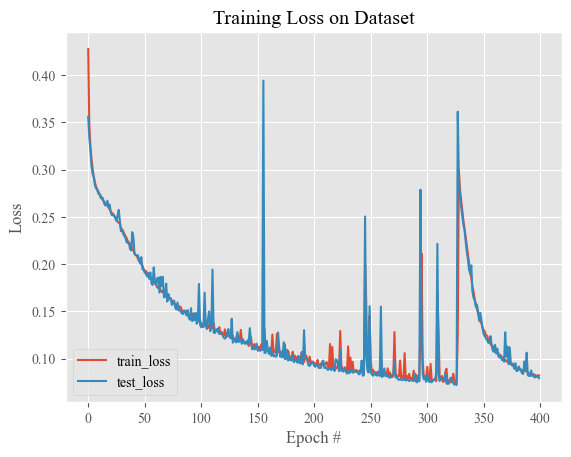

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig(pathSavePlots + f'Training_Unet_GPU_04.png',
            dpi=500,
            bbox_inches = 'tight',
            pad_inches=0.25)

# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)

# Save model

In [ ]:
path_save_models = '/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models/'
name_model = 'model_Unet_7ch_GPU_04.pth' #
# el modelo 01 toma el AOI 1 y AOI 3 para el entrenamiento cada 2 imagenes
# modelo 2 con lr = 0.0001
# modelo 3 con 200 epocas lr = 0.0001
# modelo 4 .. 400 epocas

# serialize the model to disk
#torch.save(unet, config.MODEL_PATH)
torch.save(unet.state_dict(), path_save_models + name_model)

In [ ]:
os.listdir('/content/drive/MyDrive/UIS/Doctorado_UIS2198589/1_semestre/TopicosAvanzadosGeofisica/FC_CarolinaBais/ML_models')

['model_RegLog_002.pkl',
 'model_RegLog_003.pkl',
 'model_RegLog_004.pkl',
 'model_RegLog_005.pkl',
 'model_RegLog_006.pkl',
 'model_RegLog_007.pkl',
 'model_RegLog_008.pkl',
 'model_RegLog_009.pkl',
 'model_RegLog_010.pkl',
 'model_RegLog_001.pkl',
 'model_RegLog_011.pkl',
 'model_RegLog_012.pkl',
 'model_RegLog_013.pkl',
 'model_RegLog_014.pkl',
 'model_RegLog_015.pkl',
 'model_RegLog_016.pkl',
 'model_RegLog_017.pkl',
 'model_RegLog_018.pkl',
 'model_RegLog_019.pkl',
 'model_RegLog_020.pkl',
 'model_RegLog_021.pkl',
 'model_RegLog_022.pkl',
 'model_RegLog_023.pkl',
 'model_RegLog_024.pkl',
 'model_RegLog_025.pkl',
 'model_RegLog_026.pkl',
 'model_RegLog_027.pkl',
 'model_RegLog_028.pkl',
 'model_RegLog_029.pkl',
 'model_RegLog_030.pkl',
 'df_30models_LogReg.csv',
 'model_RandForest_001.pkl',
 'model_RandForest_002.pkl',
 'model_RandForest_003.pkl',
 'model_RandForest_004.pkl',
 'model_RandForest_005.pkl',
 'model_RandForest_006.pkl',
 'model_RandForest_007.pkl',
 'model_RandForest_0

# End